# Lithology Prediction

### Raw Data Exploration

* Show head (6 rows) of raw data
* Color map of lithology over longitude and latitude
* Histogram of lithology
* Missing part visualization

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

% matplotlib inline

dfdata = pd.read_csv("data/train_clean.csv")
dfdata.head()

,longitude,latitude,lithology,bathymetry,nitrate,oxygen,phosphate,productivity,salinity,silicate,temperature
0,-180,75,4,-231.0,NaN,8.552258,NaN,310.199677,31.165499,NaN,-0.878415
1,-179,75,4,-203.0,1.702168,9.494461,0.754516,312.468658,29.931450,12.485500,-1.785413
2,-178,75,4,-304.0,1.850258,9.578869,0.735949,291.436279,30.048571,12.902109,-1.904204
3,-177,75,4,-278.0,1.960688,9.668440,0.720070,277.305817,30.211161,13.251008,-1.869162
4,-176,75,4,-247.0,2.056301,9.763065,0.706926,262.947571,30.398439,13.591722,-1.688048


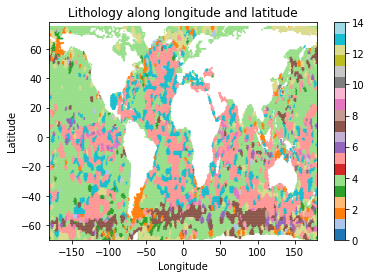

In [2]:
lon = dfdata["longitude"].values
lat = dfdata["latitude"].values
y = dfdata["lithology"].values

# plot lithology vesus longitude and latitude
def draw_global(lon, lat, y, title, cmap="tab20", vmin=0, vmax=14):
    sc = plt.scatter(lon, lat, s=0.5, c=y, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.title(title)
    plt.xlim([-180, 180])
    plt.ylim([-70, 78])
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.colorbar(sc)
    plt.show()
draw_global(lon, lat, y, "Lithology along longitude and latitude")

### Imbalanced Multiclass Classification
As we can see from the histogram of target lithology, the class distribution is not uniform. Some classes have large amount of samples whereas some classes have less samples. This enables model to cost less to predict those rare classes wrong. To fix this problem, we need to re-weight classes to obtain balanced classes.

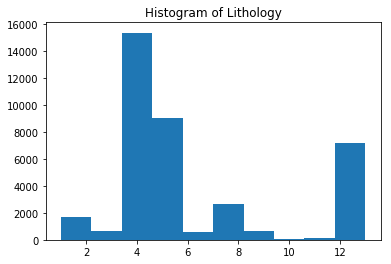

In [65]:
def draw_hist(y, title):
    # plot the histogram of lithology
    plt.hist(y)
    plt.title(title)
    plt.show()

draw_hist(y, "Histogram of Lithology")

In [28]:
training_data = dfdata.copy()

# obtain list of feature names
target = "lithology"
features = list(training_data.columns)
features.remove(target)
features.remove("longitude")
features.remove("latitude")

# impute missing with mean
fill_dict = {}
for col in training_data:
    fill_dict[col] = np.mean(training_data[col])
training_data = training_data.fillna(value=fill_dict)

### Keras - Neural Network Classification

We will deploy keras - a neural network library which is capable for running on top of Tensorflow.
The neural network has the following structure:

- Input layer
- Hidden layer 1: consists of 64 nerons
- Dropout layer : drop out 20% nerons to avoid overfitting
- Hidden layer 2: consists of 64 nerons
- Dropout layer : drop out 20% nerons to avoid overfitting
- Hidden layer 3: consists of 32 nerons
- Dropout layer : drop out 20% nerons to avoid overfitting
- Output layer

In [73]:
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.callbacks import History
from keras.wrappers.scikit_learn import KerasClassifier
from keras import regularizers
from keras.utils import np_utils
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.utils import class_weight

In [77]:
# fix random seed for reproducibility
seed = 0
np.random.seed(seed)
X = training_data[features].astype(float)
Y = training_data[target]

# standardize X
scaler = StandardScaler()
X = scaler.fit_transform(X)

# onehot target Y -> convert integers to dummy variables
encoder = LabelEncoder()
Y = encoder.fit_transform(Y)
dummy_Y = np_utils.to_categorical(Y)

# define baseline model
def baseline_model():
    activation = "relu"
    dropout_ratio = 0.1
    initializer = "random_uniform"
    numclass = dummy_Y.shape[1]
    model = Sequential()
    model.add(Dense(64, input_dim=X.shape[1], activation=activation, kernel_initializer=initializer))
    model.add(Dropout(rate=dropout_ratio))
    model.add(Dense(64, activation=activation, kernel_initializer=initializer))
    model.add(Dropout(rate=dropout_ratio))
    model.add(Dense(32, activation=activation, kernel_initializer=initializer))
    model.add(Dropout(rate=dropout_ratio))
    model.add(Dense(numclass, activation="softmax", kernel_initializer=initializer))
    # compile
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

# class reweighting for imbalanced class
weight = class_weight.compute_class_weight('balanced', np.unique(Y), Y)

# training -> cross validation
estimator = KerasClassifier(build_fn=baseline_model, epochs=200, batch_size=5, verbose=True,
                           class_weight=weight)
kfold = KFold(n_splits=3, shuffle=True, random_state=seed)
results = cross_val_predict(estimator, X, dummy_Y, cv=kfold)

d:\software\anaconda\envs\tensorflow\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
INFO (theano.gof.compilelock): Refreshing lock C:\Users\joyce\AppData\Local\Theano\compiledir_Windows-10-10.0.17134-SP0-Intel64_Family_6_Model_158_Stepping_10_GenuineIntel-3.5.5-64\lock_dir\lock


Epoch 1/150
25366/25366 [==============================] - 2s 98us/step - loss: 1.5236 - acc: 0.4770
Epoch 2/150
25366/25366 [==============================] - 3s 102us/step - loss: 1.4168 - acc: 0.5156
Epoch 3/150
25366/25366 [==============================] - 3s 100us/step - loss: 1.3881 - acc: 0.5235
Epoch 4/150
25366/25366 [==============================] - 3s 101us/step - loss: 1.3723 - acc: 0.5276
Epoch 5/150
25366/25366 [==============================] - 3s 101us/step - loss: 1.3594 - acc: 0.5336
Epoch 6/150
25366/25366 [==============================] - 3s 101us/step - loss: 1.3502 - acc: 0.5355
Epoch 7/150
25366/25366 [==============================] - 3s 100us/step - loss: 1.3401 - acc: 0.5376
Epoch 8/150
25366/25366 [==============================] - 3s 101us/step - loss: 1.3333 - acc: 0.5405
Epoch 9/150
25366/25366 [==============================] - 3s 101us/step - loss: 1.3239 - acc: 0.5416
Epoch 10/150
25366/25366 [==============================] - 3s 101us/step - loss: 1

25366/25366 [==============================] - 3s 101us/step - loss: 1.1673 - acc: 0.5772
Epoch 81/150
25366/25366 [==============================] - 3s 100us/step - loss: 1.1659 - acc: 0.5754
Epoch 82/150
25366/25366 [==============================] - 3s 100us/step - loss: 1.1642 - acc: 0.5781
Epoch 83/150
25366/25366 [==============================] - 3s 101us/step - loss: 1.1654 - acc: 0.5760
Epoch 84/150
25366/25366 [==============================] - 3s 100us/step - loss: 1.1658 - acc: 0.5789
Epoch 85/150
25366/25366 [==============================] - 3s 100us/step - loss: 1.1676 - acc: 0.5776
Epoch 86/150
25366/25366 [==============================] - 3s 101us/step - loss: 1.1656 - acc: 0.5767
Epoch 87/150
25366/25366 [==============================] - 3s 101us/step - loss: 1.1625 - acc: 0.5777
Epoch 88/150
25366/25366 [==============================] - 3s 101us/step - loss: 1.1641 - acc: 0.5779
Epoch 89/150
25366/25366 [==============================] - 3s 101us/step - loss: 1.16

INFO (theano.gof.compilelock): Refreshing lock C:\Users\joyce\AppData\Local\Theano\compiledir_Windows-10-10.0.17134-SP0-Intel64_Family_6_Model_158_Stepping_10_GenuineIntel-3.5.5-64\lock_dir\lock


12683/12683 [==============================] - 0s 21us/step


d:\software\anaconda\envs\tensorflow\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Epoch 1/150
25366/25366 [==============================] - 3s 101us/step - loss: 1.5188 - acc: 0.4745
Epoch 2/150
25366/25366 [==============================] - 3s 105us/step - loss: 1.4098 - acc: 0.5190
Epoch 3/150
25366/25366 [==============================] - 3s 104us/step - loss: 1.3819 - acc: 0.5253
Epoch 4/150
25366/25366 [==============================] - 3s 104us/step - loss: 1.3641 - acc: 0.5317
Epoch 5/150
25366/25366 [==============================] - 3s 105us/step - loss: 1.3541 - acc: 0.5332
Epoch 6/150
25366/25366 [==============================] - 3s 105us/step - loss: 1.3428 - acc: 0.5360
Epoch 7/150
25366/25366 [==============================] - 3s 105us/step - loss: 1.3366 - acc: 0.5376
Epoch 8/150
25366/25366 [==============================] - 3s 105us/step - loss: 1.3254 - acc: 0.5435
Epoch 9/150
25366/25366 [==============================] - 3s 105us/step - loss: 1.3199 - acc: 0.5464
Epoch 10/150
25366/25366 [==============================] - 3s 104us/step - loss: 

25366/25366 [==============================] - 3s 104us/step - loss: 1.1694 - acc: 0.5857
Epoch 81/150
25366/25366 [==============================] - 3s 103us/step - loss: 1.1716 - acc: 0.5830
Epoch 82/150
25366/25366 [==============================] - 3s 104us/step - loss: 1.1707 - acc: 0.5827
Epoch 83/150
25366/25366 [==============================] - 3s 104us/step - loss: 1.1680 - acc: 0.5845
Epoch 84/150
25366/25366 [==============================] - 3s 103us/step - loss: 1.1708 - acc: 0.5831
Epoch 85/150
25366/25366 [==============================] - 3s 103us/step - loss: 1.1648 - acc: 0.5858
Epoch 86/150
25366/25366 [==============================] - 3s 104us/step - loss: 1.1649 - acc: 0.5866
Epoch 87/150
25366/25366 [==============================] - 3s 103us/step - loss: 1.1663 - acc: 0.5832
Epoch 88/150
25366/25366 [==============================] - 3s 103us/step - loss: 1.1677 - acc: 0.5864
Epoch 89/150
25366/25366 [==============================] - 3s 103us/step - loss: 1.16

d:\software\anaconda\envs\tensorflow\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Epoch 1/150
25366/25366 [==============================] - 3s 103us/step - loss: 1.5366 - acc: 0.4682
Epoch 2/150
25366/25366 [==============================] - 3s 103us/step - loss: 1.4208 - acc: 0.5095
Epoch 3/150
25366/25366 [==============================] - 3s 103us/step - loss: 1.3875 - acc: 0.5228
Epoch 4/150
25366/25366 [==============================] - 3s 104us/step - loss: 1.3761 - acc: 0.5269
Epoch 5/150
25366/25366 [==============================] - 3s 104us/step - loss: 1.3620 - acc: 0.5315
Epoch 6/150
25366/25366 [==============================] - 3s 104us/step - loss: 1.3555 - acc: 0.5358
Epoch 7/150
25366/25366 [==============================] - 3s 104us/step - loss: 1.3447 - acc: 0.5364
Epoch 8/150
25366/25366 [==============================] - 3s 103us/step - loss: 1.3359 - acc: 0.5378
Epoch 9/150
25366/25366 [==============================] - 3s 103us/step - loss: 1.3271 - acc: 0.5433
Epoch 10/150
25366/25366 [==============================] - 3s 104us/step - loss: 

25366/25366 [==============================] - 3s 102us/step - loss: 1.1697 - acc: 0.5793
Epoch 81/150
25366/25366 [==============================] - 3s 102us/step - loss: 1.1676 - acc: 0.5814
Epoch 82/150
25366/25366 [==============================] - 3s 102us/step - loss: 1.1642 - acc: 0.5839
Epoch 83/150
25366/25366 [==============================] - 3s 102us/step - loss: 1.1676 - acc: 0.5810
Epoch 84/150
25366/25366 [==============================] - 3s 102us/step - loss: 1.1682 - acc: 0.5817
Epoch 85/150
25366/25366 [==============================] - 3s 103us/step - loss: 1.1602 - acc: 0.5854
Epoch 86/150
25366/25366 [==============================] - 3s 103us/step - loss: 1.1701 - acc: 0.5823
Epoch 87/150
25366/25366 [==============================] - 3s 103us/step - loss: 1.1662 - acc: 0.5809
Epoch 88/150
25366/25366 [==============================] - 3s 102us/step - loss: 1.1649 - acc: 0.5827
Epoch 89/150
25366/25366 [==============================] - 3s 101us/step - loss: 1.16

Accuracy = 0.603826644589871


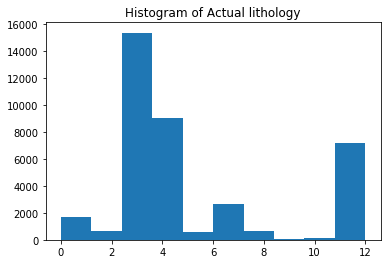

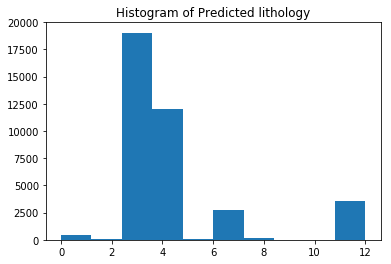

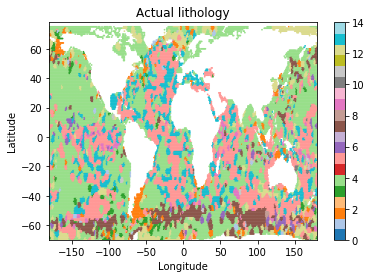

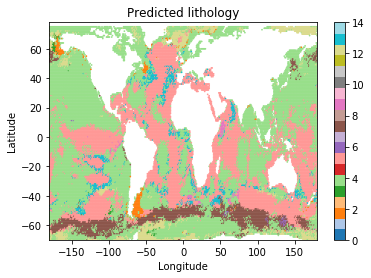

In [78]:
print("Accuracy = {}".format(accuracy_score(Y, results)))
draw_hist(Y, "Histogram of Actual lithology")
draw_hist(results, "Histogram of Predicted lithology")
draw_global(lon, lat, y, "Actual lithology")
draw_global(lon, lat, results + 1, "Predicted lithology")